In [289]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

Exercise 1


(512, 512)
int16


C:\Users\frede\AppData\Local\Temp\ipykernel_16620\699138764.py:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img, vmin=0, vmax=150, cmap='gray')
C:\Users\frede\AppData\Local\Temp\ipykernel_16620\699138764.py:8: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


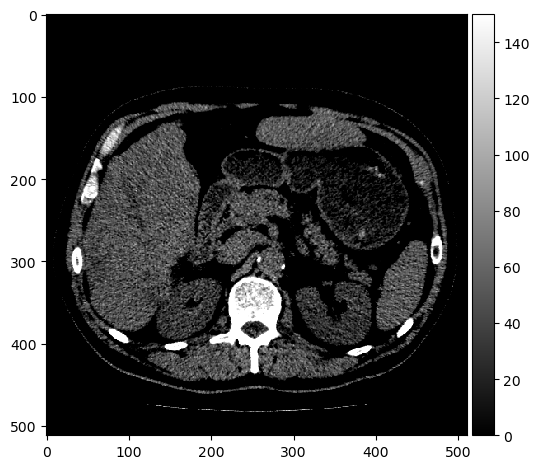

In [290]:
in_dir = "data/"
ct = dicom.dcmread(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

Exercise 2

In [291]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

In [292]:
mean_hu = np.mean(spleen_values)
std_hu = np.std(spleen_values)

print(f"Mean HU in spleen: {mean_hu:.2f}")
print(f"Standard deviation HU in spleen: {std_hu:.2f}")


Mean HU in spleen: 49.48
Standard deviation HU in spleen: 15.00


Exercise 3

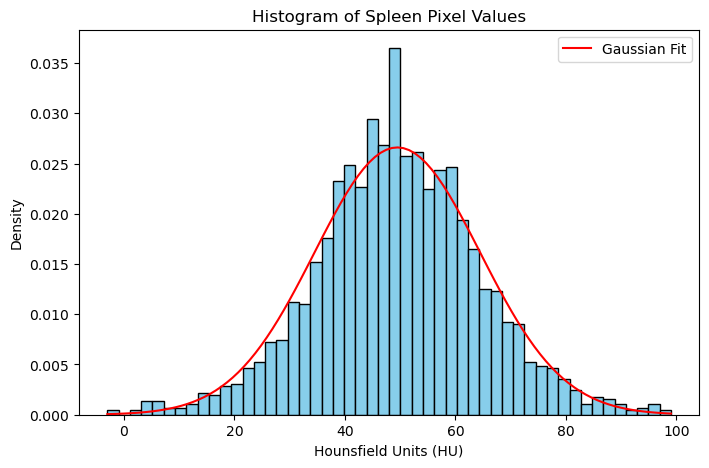

In [293]:
plt.figure(figsize=(8, 5))
plt.hist(spleen_values, bins=50, color='skyblue', edgecolor='black', density=True)
plt.title("Histogram of Spleen Pixel Values")
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Density")

# Overlay Gaussian fit
mean = np.mean(spleen_values)
std = np.std(spleen_values)
x = np.linspace(min(spleen_values), max(spleen_values), 100)
gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
plt.plot(x, gaussian, color='red', label='Gaussian Fit')
plt.legend()

plt.show()


Yes it follows a gaussian distribution pretty well

Exercise 4

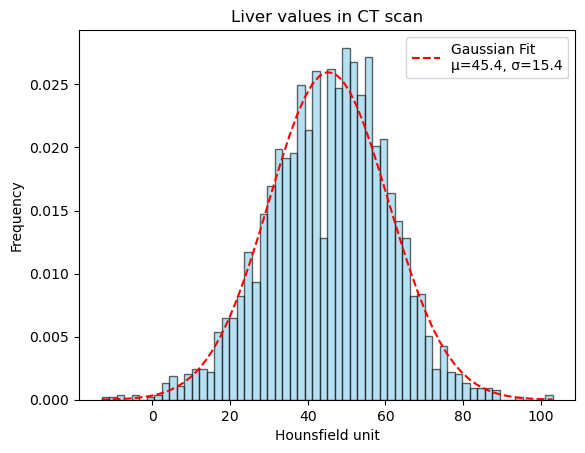

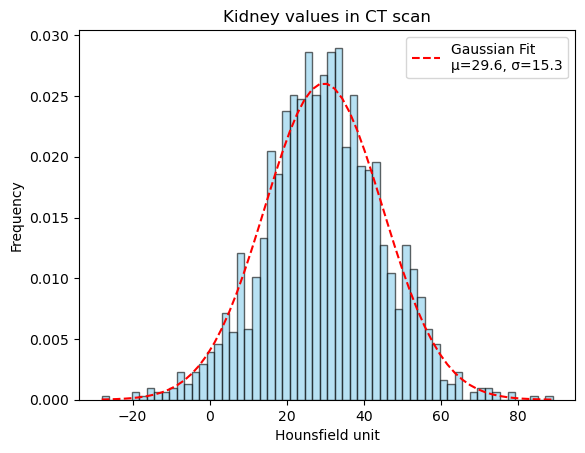

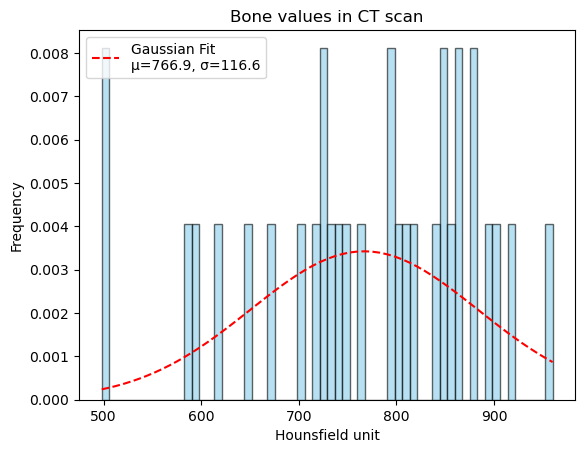

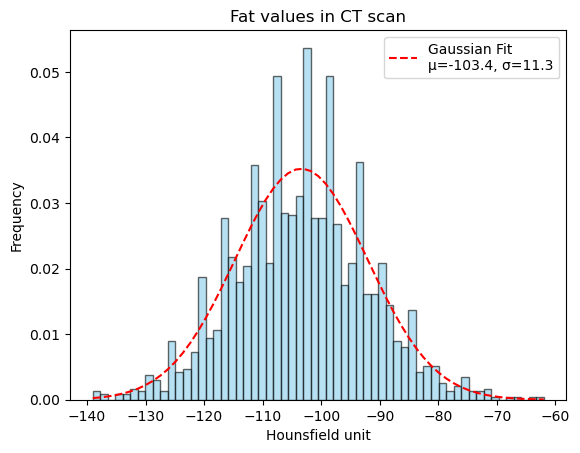

In [294]:
liver_mask = io.imread(in_dir + 'LiverROI.png') > 0
kidney_mask = io.imread(in_dir + 'KidneyROI.png') > 0
bone_mask = io.imread(in_dir + 'BoneROI.png') > 0
fat_mask = io.imread(in_dir + 'FatROI.png') > 0

liver_values = img[liver_mask]
kidney_values = img[kidney_mask]
bone_values = img[bone_mask]
fat_values = img[fat_mask]

from scipy.stats import norm
import matplotlib.pyplot as plt

tissues = {
    'Liver': liver_values,
    'Kidney': kidney_values,
    'Bone': bone_values,
    'Fat': fat_values
}

for name, values in tissues.items():
    mu = np.mean(values)
    std = np.std(values)
    n, bins, patches = plt.hist(values, 60, density=1, alpha=0.6, color='skyblue', edgecolor='black')
    pdf = norm.pdf(bins, mu, std)
    plt.plot(bins, pdf, 'r--', label=f'Gaussian Fit\nμ={mu:.1f}, σ={std:.1f}')
    plt.xlabel('Hounsfield unit')
    plt.ylabel('Frequency')
    plt.title(f'{name} values in CT scan')
    plt.legend()
    plt.show()


They dont all look gaussian distributed, fat and especially bone vary a lot

Exercise 5

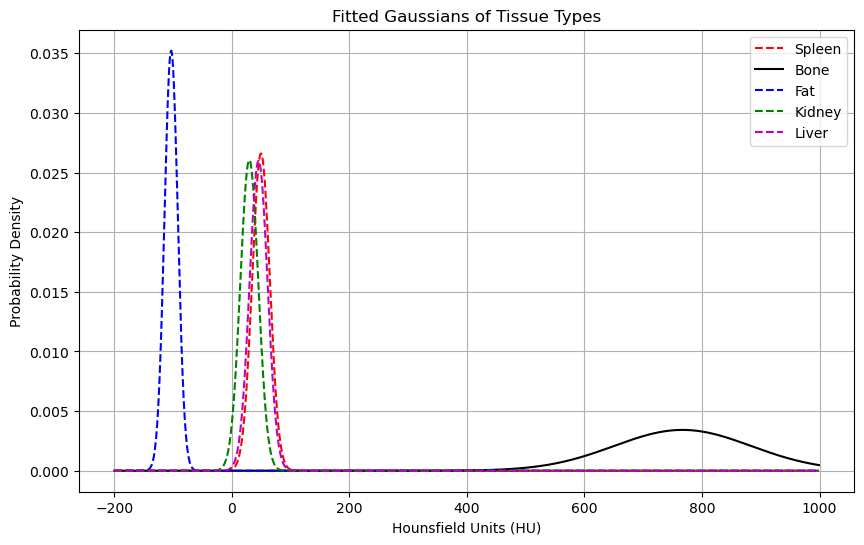

In [295]:
# Hounsfield unit range
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)

# Compute mean and std for each tissue
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

mu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)

mu_kidney = np.mean(kidney_values)
std_kidney = np.std(kidney_values)

mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

# Compute PDFs
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(hu_range, pdf_spleen, 'r--', label="Spleen")
plt.plot(hu_range, pdf_bone, 'k', label="Bone")
plt.plot(hu_range, pdf_fat, 'b--', label="Fat")
plt.plot(hu_range, pdf_kidney, 'g--', label="Kidney")
plt.plot(hu_range, pdf_liver, 'm--', label="Liver")
plt.title("Fitted Gaussians of Tissue Types")
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

It is easy to seperate fat from other soft tissues and bone, but it is hard to seperate kidney, liver and spleen as they all overlap

Exercise 6

The classes defined are:
- Fat (-200,-50)
- Soft tissue (spleen, kidney, liver) (-50, 110)
- Bone (400,1000)

Exercise 7

In [296]:
soft_tissue_values = np.concatenate([spleen_values, liver_values, kidney_values])

mu_fat = np.mean(fat_values)
mu_soft = np.mean(soft_tissue_values)
std_soft = np.std(soft_tissue_values)
mu_bone = np.mean(bone_values)

threshold_fat_soft = (mu_fat + mu_soft) / 2
threshold_soft_bone = (mu_soft + mu_bone) / 2

# Background threshold is fixed
background_range = (-np.inf, -200)

# Fat: from -200 to midpoint between fat and soft tissue
fat_range = (-200, threshold_fat_soft)

# Soft tissue: from fat-soft midpoint to soft-bone midpoint
soft_tissue_range = (threshold_fat_soft, threshold_soft_bone)

# Bone: from soft-bone midpoint upward
bone_range = (threshold_soft_bone, np.inf)

print(background_range, fat_range, soft_tissue_range, bone_range)

(-inf, -200) (-200, np.float64(-30.190784679297884)) (np.float64(-30.190784679297884), np.float64(404.9731539483675)) (np.float64(404.9731539483675), inf)


Exercise 8

In [297]:
t_background = -200
fat_img = (img > t_background) & (img <= threshold_fat_soft)

soft_img = (img > threshold_fat_soft) & (img <= threshold_soft_bone)

bone_img = img > threshold_soft_bone

Exercise 9

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


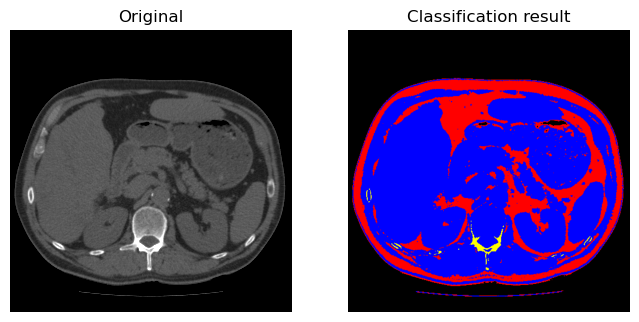

In [298]:
label_img = fat_img + 2 * soft_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')

It looks relatively correct, but the bone is not marked properly. Some of the bone mass is not shown as bone

Exercise 9 has been completed earlier in the set

Exercise 10

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


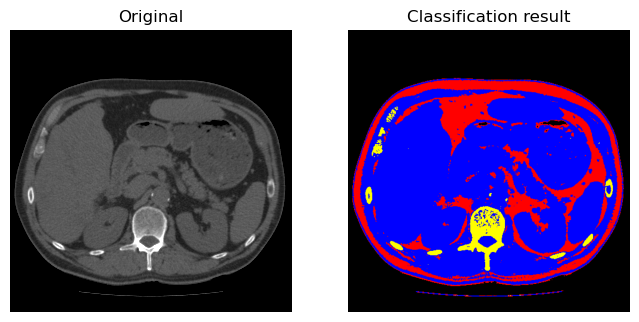

In [299]:
# Fat: from -200 to midpoint between fat and soft tissue
new_fat_range = (-200, -50)

# Soft tissue: from fat-soft midpoint to soft-bone midpoint
new_soft_tissue_range = (-50, 110)

# Bone: from soft-bone midpoint upward
new_bone_range = (200, np.inf)


new_fat_img = (img > new_fat_range[0]) & (img <= new_fat_range[1])
new_soft_img = (img > new_soft_tissue_range[0]) & (img <= new_soft_tissue_range[1])
new_bone_img = img > new_soft_tissue_range[1]

new_label_img = new_fat_img + 2 * new_soft_img + 3 * new_bone_img
new_image_label_overlay = label2rgb(new_label_img)
show_comparison(img, new_image_label_overlay, 'Classification result')

Way better. The one with the mean does not take into account that some distributions may have more spread than others

Exercise 11

In [300]:
hu_values = np.arange(-200, 1000)

lookup_table = []

for hu in hu_values:
    p_fat = norm.pdf(hu, mu_fat, std_fat)
    p_soft = norm.pdf(hu, mu_soft, std_soft)
    p_bone = norm.pdf(hu, mu_bone, std_bone)

    # Assign class with highest probability
    if p_fat > p_soft and p_fat > p_bone:
        lookup_table.append('fat')
    elif p_soft > p_fat and p_soft > p_bone:
        lookup_table.append('soft')
    else:
        lookup_table.append('bone')

boundaries = []
for i in range(1, len(lookup_table)):
    if lookup_table[i] != lookup_table[i - 1]:
        boundaries.append(hu_values[i])

print("Class boundaries:", boundaries)

Class boundaries: [np.int64(-44), np.int64(141)]


Then out optimal class ranges are:
- Fat: HU ≤ -44
- Soft Tissue: -44 < HU ≤ 141
- Bone: HU > 141


Exercise 11 (error in readme)

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\3133138632.py:11: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(spleen_label_colour)
C:\Users\frede\AppData\Local\Temp\ipykernel_16620\3133138632.py:13: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


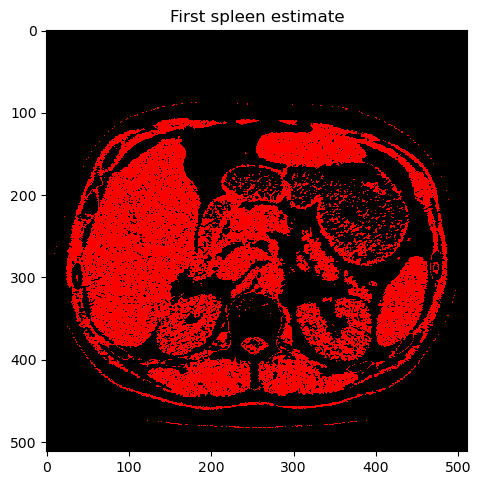

In [301]:
t_1 = 20     # Lower HU threshold for spleen
t_2 = 80   # Upper HU threshold for spleen

# Estimate spleen region based on HU range
spleen_estimate = (img > t_1) & (img < t_2)

# Convert binary mask to color overlay
spleen_label_colour = color.label2rgb(spleen_estimate)

# Display the result
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

Exercise 12

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


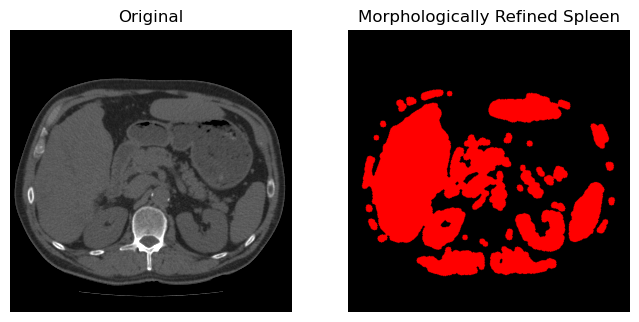

In [302]:
footprint_close = disk(2)
closed = binary_closing(spleen_estimate, footprint_close)

footprint_open = disk(5)
opened = binary_opening(closed, footprint_open)

show_comparison(img, label2rgb(opened), 'Morphologically Refined Spleen')

Exercise 12.2

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


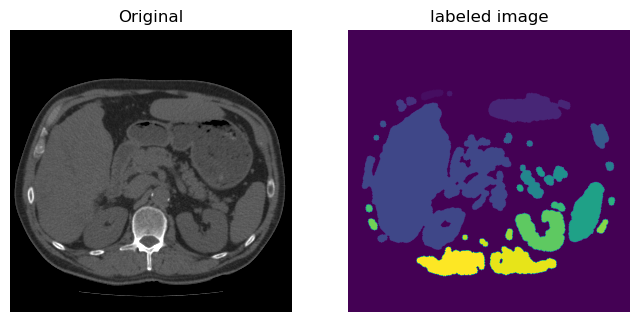

In [303]:
label_img = measure.label(opened)

regions = measure.regionprops(label_img)

show_comparison(img, label_img, "labeled image")

Exercise 14

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


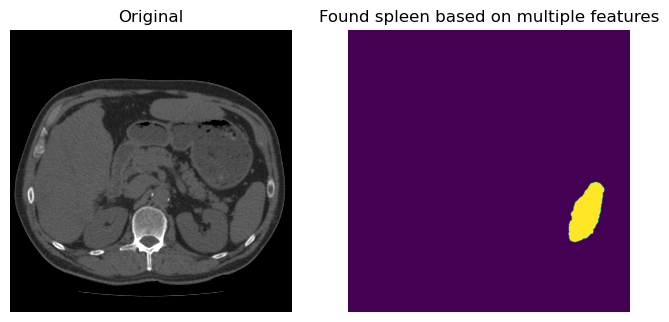

In [304]:
min_area = 4200
max_area = 5000
min_perimeter = 280
max_perimeter = 350

# Optional: add more features
min_solidity = 0.90
max_eccentricity = 0.95

# Filter blobs
label_img_filter = label_img.copy()
for region in regions:
    if (
        region.area < min_area or region.area > max_area or
        region.perimeter < min_perimeter or region.perimeter > max_perimeter or
        region.solidity < min_solidity or region.eccentricity > max_eccentricity
    ):
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0

# Create binary image from filtered labels
i_filtered = label_img_filter > 0
show_comparison(img, i_filtered, 'Found spleen based on multiple features')


Exercise 15

In [305]:
def spleen_finder(img):
    # Step 1: Thresholding based on HU range
    t1, t2 = 20, 80
    spleen_estimate = (img > t1) & (img < t2)

    # Step 2: Morphological operations
    closed = binary_closing(spleen_estimate, disk(2))
    opened = binary_opening(closed, disk(5))

    # Step 3: Label connected components
    label_img = measure.label(opened)
    regions = measure.regionprops(label_img)

    # Step 4: Feature-based filtering
    min_area = 3500
    max_area = 6000
    min_perimeter = 280
    max_perimeter = 350
    min_solidity = 0.90
    max_eccentricity = 0.95

    label_img_filter = label_img.copy()
    for region in regions:
        if (
            region.area < min_area or region.area > max_area or
            region.perimeter < min_perimeter or region.perimeter > max_perimeter or
            region.solidity < min_solidity or region.eccentricity > max_eccentricity
        ):
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Step 5: Return binary spleen mask
    spleen_mask = label_img_filter > 0
    return spleen_mask


Exercise 16

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


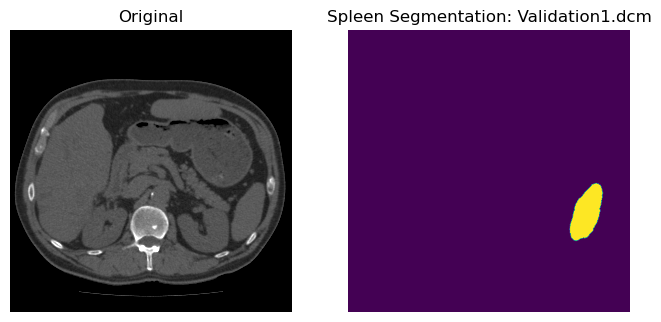

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


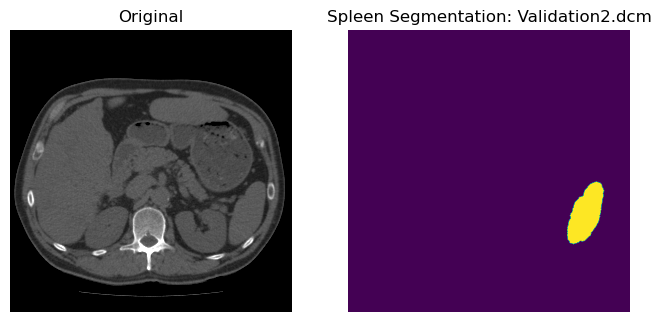

C:\Users\frede\AppData\Local\Temp\ipykernel_16620\438281737.py:22: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


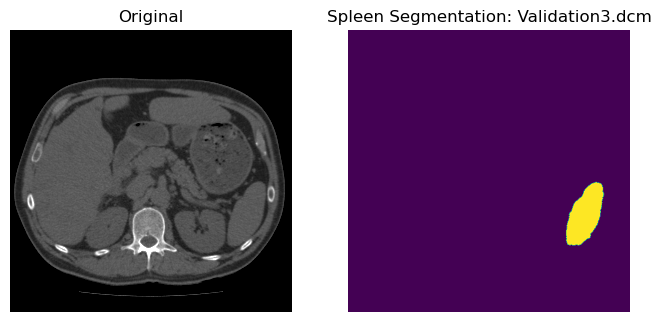

In [306]:
validation_files = ['Validation1.dcm', 'Validation2.dcm', 'Validation3.dcm']
in_dir = 'data/'

for file in validation_files:
    ct = dicom.dcmread(in_dir + file)
    img = ct.pixel_array

    # Run spleen finder
    spleen_mask = spleen_finder(img)

    # Show result
    show_comparison(img, spleen_mask, f'Spleen Segmentation: {file}')


Exercise 17

In [307]:
ground_truth_files = ['Validation1_spleen.png', 'Validation2_spleen.png', 'Validation3_spleen.png']
in_dir = 'data/'

for val_file, gt_file in zip(validation_files, ground_truth_files):
    # Load CT image
    ct = dicom.dcmread(in_dir + val_file)
    img = ct.pixel_array

    # Run spleen segmentation
    spleen_mask = spleen_finder(img)

    # Load ground truth mask
    ground_truth_img = io.imread(in_dir + gt_file)
    gt_bin = ground_truth_img > 0

    # Compute DICE score
    dice_score = 1 - distance.dice(spleen_mask.ravel(), gt_bin.ravel())
    print(f"DICE score for {val_file}: {dice_score:.4f}")


DICE score for Validation1.dcm: 0.9547
DICE score for Validation2.dcm: 0.9621
DICE score for Validation3.dcm: 0.9727


Very close to 1!

Exercise 18

In [308]:
test_files = ['Test1.dcm', 'Test2.dcm', 'Test3.dcm']
ground_truth_files = ['Test1_spleen.png', 'Test2_spleen.png', 'Test3_spleen.png']

for test_file, gt_file in zip(test_files, ground_truth_files):
    img = dicom.dcmread(in_dir + test_file).pixel_array
    spleen_mask = spleen_finder(img)
    gt_bin = io.imread(in_dir + gt_file) > 0
    dice_score = 1 - distance.dice(spleen_mask.ravel(), gt_bin.ravel())
    print(f"DICE score for {test_file}: {dice_score:.4f}")


DICE score for Test1.dcm: 0.0000
DICE score for Test2.dcm: 0.0000
DICE score for Test3.dcm: 0.9672
